# Determinants of Trust in Public Institutions: The Role of Overwork, Income, and Health

## Pandas

In [1]:
import pandas as pd
import os
import stata_setup

# Set the Stata path
stata_setup.config("C:/Program Files/StataNow19", "se")
# Check STATA version
print("Stata initialized in mode:", stata_setup.__version__)


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      StataNow 19.5
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2025 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-782-8272        https://www.stata.com
                                   979-696-4600        service@stata.com

Stata license: Unlimited-user network, expiring  1 May 2026
Serial number: 401909303799
  Licensed to: Adam Wawerski
               Szkoła Główna Handlowa w Warszawie

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.
Stata initialized in mode: 0.1.3


### Load data to pandas

In [2]:
file_path = 'C:/Users/adamw/source/repos/microeconomics/data/DE_oczyszczone_2013_personal_final.xlsx'
try:
    df = pd.read_excel(file_path)
    print(f"Data successfully loaded from {file_path}")
except FileNotFoundError:
    print(f"File not found: {file_path}")



Data successfully loaded from C:/Users/adamw/source/repos/microeconomics/data/DE_oczyszczone_2013_personal_final.xlsx


In [3]:
display(df)
display(df.dtypes)

,PB010,PB020,PB030,PB040,PB100,PB110,PB120,PB140,PB150,PB190,...,PW130,PW140,PW150,PW160,PW170,PW180,PW190,PW200,PW210,PW220
0,2013,DE,35601,3057.583187,2,2013,45,1977,1,2.0,...,3.0,6.0,10.0,8.0,2.0,1.0,NaN,7.0,8.0,NaN
1,2013,DE,44701,3057.583187,3,2013,15,1936,1,2.0,...,7.0,4.0,99.0,8.0,1.0,1.0,8.0,0.0,6.0,2.0
2,2013,DE,59901,3057.583187,2,2013,45,1952,2,2.0,...,3.0,8.0,9.0,10.0,1.0,1.0,NaN,10.0,6.0,2.0
3,2013,DE,71101,3057.583187,2,2013,15,1938,2,2.0,...,5.0,7.0,5.0,8.0,1.0,NaN,6.0,9.0,5.0,3.0
4,2013,DE,79501,3057.583187,2,2013,25,1950,2,5.0,...,0.0,2.0,NaN,2.0,1.0,NaN,5.0,2.0,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22036,2013,DE,401030902,2927.052632,3,2013,10,1972,2,1.0,...,8.0,7.0,9.0,99.0,1.0,1.0,6.0,6.0,8.0,NaN
22037,2013,DE,401042201,2927.052632,2,2013,20,1969,1,2.0,...,5.0,8.0,3.0,10.0,NaN,1.0,7.0,9.0,9.0,2.0
22038,2013,DE,401042202,2927.052632,3,2013,45,1972,2,5.0,...,4.0,NaN,8.0,8.0,1.0,1.0,7.0,9.0,7.0,1.0
22039,2013,DE,401100801,2927.052632,2,2013,20,1978,2,2.0,...,3.0,1.0,7.0,9.0,1.0,1.0,5.0,8.0,NaN,1.0


PB010      int64
PB020     object
PB030      int64
PB040    float64
PB100      int64
          ...   
PW180    float64
PW190    float64
PW200    float64
PW210    float64
PW220    float64
Length: 78, dtype: object

### Convert relevant columns to numeric (handling potential issues)

In [4]:
numeric_columns = ['PW030', 'PY010G', 'PY080G', 'PY090G', 'PY100G', 'PH020', 'PB150', 'PB190']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
df

,PB010,PB020,PB030,PB040,PB100,PB110,PB120,PB140,PB150,PB190,...,PW130,PW140,PW150,PW160,PW170,PW180,PW190,PW200,PW210,PW220
0,2013,DE,35601,3057.583187,2,2013,45,1977,1,2.0,...,3.0,6.0,10.0,8.0,2.0,1.0,NaN,7.0,8.0,NaN
1,2013,DE,44701,3057.583187,3,2013,15,1936,1,2.0,...,7.0,4.0,99.0,8.0,1.0,1.0,8.0,0.0,6.0,2.0
2,2013,DE,59901,3057.583187,2,2013,45,1952,2,2.0,...,3.0,8.0,9.0,10.0,1.0,1.0,NaN,10.0,6.0,2.0
3,2013,DE,71101,3057.583187,2,2013,15,1938,2,2.0,...,5.0,7.0,5.0,8.0,1.0,NaN,6.0,9.0,5.0,3.0
4,2013,DE,79501,3057.583187,2,2013,25,1950,2,5.0,...,0.0,2.0,NaN,2.0,1.0,NaN,5.0,2.0,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22036,2013,DE,401030902,2927.052632,3,2013,10,1972,2,1.0,...,8.0,7.0,9.0,99.0,1.0,1.0,6.0,6.0,8.0,NaN
22037,2013,DE,401042201,2927.052632,2,2013,20,1969,1,2.0,...,5.0,8.0,3.0,10.0,NaN,1.0,7.0,9.0,9.0,2.0
22038,2013,DE,401042202,2927.052632,3,2013,45,1972,2,5.0,...,4.0,NaN,8.0,8.0,1.0,1.0,7.0,9.0,7.0,1.0
22039,2013,DE,401100801,2927.052632,2,2013,20,1978,2,2.0,...,3.0,1.0,7.0,9.0,1.0,1.0,5.0,8.0,NaN,1.0


### Data celaning

In [5]:
# List of selected variables
selected_columns = [
# demo
    'PB040',  # Personal cross-sectional weight [all household members aged 16 and over]
    'PB120',  # Minutes to complete the personal questionnaire
    'PB140',  # Year of birth
    'PB150',  # Sex
    'PB190',  # Marital status
    'PE010',  # Participation in formal education and training (student or apprentice)
    'PL031',  # SELF-DEFINED CURRENT ECONOMIC STATUS

    # praca
    'PL015',  # PERSON HAS EVER WORKED
    'PL020',  # ACTIVELY LOOKING FOR A JOB
    'PL025',  # AVAII ABLE FOR WORK
    'PL040',  # Status in employment (main job)
    'PL060',  # Number of hours usually worked per week in the main job
    'PL100',  # Total number of hours per week usually worked in the second, third,..jobs..„...387
    'PL111',  # Economic activity of the local unit for the main job
    'PL130',  # NUMBER OF PERSONS WORKING AT THE LOCAL UNIT
    'PL140',  # TYPE OF CONTRACT
    'PL150',  # Supervisory responsibility in the main job.
    'PL160',  # CHANGE OF JOB SINCE LAST YEAR
    'PL180',  # Mosm RECENT CHANGE IN THE INDIVIDUAL'S ACTIVITY STATUS
    'PL190',  # WHEN BEGAN FIRST REGULAR JOB

    # zdrowie
    'PH010',  # Self-perceived General health
    'PH020',  # Suffer from any chronic [long-standing] illness or condition: 1 yes, 2 no, -1 missing, -3 not selected respondent
    'PH030',  # Limitation in activities because of health problems: 1 yes strongly limited, 2 yes limited, 3 no not limited, -1 missing, -3 not selected respondent
    'PH040',  # Unmet need for medical examination or treatment
    'PH050',  # Main reason for unmet need for medical examination treatment
    'PH060',  # Unmet need for dental examination treatment
    'PH070',  # Main reason for unmet need for dental examination or treatment

    # finanse
    'PY010G',  # Employee cash or near cash income
    'PY020G',  # Non-cash employee income
    'PY035G',  # Contributions to individual private pension plans
    'PY050G',  # Cash benefits or losses from self-employment
    'PY090G',  # Unemployment benefits
    'PY100G',  # Old-age benefits
    'PY110G',  # Survivor's benefits
    'PY120G',  # Sickeness benefits
    'PY130G',  # Disability benefits
    'PY140G',  # Education related allowances

    # dobrobyt
    'PD020',  # Replace worn-out clothes by some new (not second-hand) ones
    'PD030',  # Two pairs of properly fitting shoes
    'PD050',  # Get-together with friends/family [relatives] for a drink/meal at least once a week
    'PD060',  # Regularly participate in a leisure activity
    'PD070',  # Spend a small amount of money each week on yourself

    # nastroje
    'PW010',  # Overall life satisfaction
    'PW040',  # SATISFACTION WITH ACCOMMODATION
    'PW050',  # BEING VERY NERVOUS
    'PW100',  # JOB SATISFACTION
    'PW110',  # SATISFACTION WITH COMMUTING TIME
    'PW120',  # SATISFACTION WITH TIME USE
    'PW130',  # TRUST IN THE POLITICAL SYSTEM: 0-10 From 0 (No trust at all) to 10 (Complete trust), 99 Do not know
    'PW140',  # TRUST IN THE LEGAL SYSTEM: 0-10 From 0 (No trust at all) to 10, (Complete trust) 99 Do not know
    'PW150',  # TRUST IN THE POLICE: 0-10 From 0 (No trust at all) to 10 (Complete trust), 99 Do not know
    'PW160',  # SATISFACTION WITH PERSONAL RELATIONSHIPS
    'PW170',  # PERSONAL MATTERS (ANYONE TO DISCUSS WITH)
    'PW180',  # HELP FROM OTHERS
    'PW190',  # TRUST IN OTHERS
    'PW200',  # SATISFACTION WITH RECREATIONAL OR GREEN AREAS
    'PW220'   # PHYSICAL SECURITY
]
# Select only the relevant columns
clear_df = df[selected_columns]

# Standardize column names to lowercase
# df.columns = [col.lower() for col in df.columns]
clear_df

,PB040,PB120,PB140,PB150,PB190,PE010,PL031,PL015,PL020,PL025,...,PW120,PW130,PW140,PW150,PW160,PW170,PW180,PW190,PW200,PW220
0,3057.583187,45,1977,1,2.0,2,1.0,1.0,NaN,NaN,...,7.0,3.0,6.0,10.0,8.0,2.0,1.0,NaN,7.0,NaN
1,3057.583187,15,1936,1,2.0,2,7.0,1.0,NaN,NaN,...,6.0,7.0,4.0,99.0,8.0,1.0,1.0,8.0,0.0,2.0
2,3057.583187,45,1952,2,2.0,1,11.0,1.0,NaN,NaN,...,3.0,3.0,8.0,9.0,10.0,1.0,1.0,NaN,10.0,2.0
3,3057.583187,15,1938,2,2.0,2,7.0,1.0,NaN,NaN,...,8.0,5.0,7.0,5.0,8.0,1.0,NaN,6.0,9.0,3.0
4,3057.583187,25,1950,2,5.0,2,1.0,NaN,NaN,NaN,...,5.0,0.0,2.0,NaN,2.0,1.0,NaN,5.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22036,2927.052632,10,1972,2,1.0,2,2.0,1.0,NaN,NaN,...,5.0,8.0,7.0,9.0,99.0,1.0,1.0,6.0,6.0,NaN
22037,2927.052632,20,1969,1,2.0,2,1.0,1.0,NaN,NaN,...,99.0,5.0,8.0,3.0,10.0,NaN,1.0,7.0,9.0,2.0
22038,2927.052632,45,1972,2,5.0,2,1.0,NaN,NaN,NaN,...,NaN,4.0,NaN,8.0,8.0,1.0,1.0,7.0,9.0,1.0
22039,2927.052632,20,1978,2,2.0,1,1.0,NaN,NaN,NaN,...,5.0,3.0,1.0,7.0,9.0,1.0,1.0,5.0,8.0,1.0


Check for missing values

In [6]:
missing_data = clear_df.isnull().sum()
print("\nMissing data per column:")
print(missing_data[missing_data > 0])


Missing data per column:
PB190       159
PL031       158
PL015     11988
PL020     17112
PL025     21226
PL040      1630
PL060     10101
PL100     21066
PL111      9407
PL130     10010
PL140      2835
PL150      2782
PL160     10068
PL180     21066
PL190      1997
PH010        28
PH020        48
PH030       210
PH050     20743
PH070     21198
PY010G        5
PY090G        5
PY100G        1
PD020       192
PD030       180
PD050       195
PD060       153
PD070       209
PW010      3449
PW040      3412
PW050      3530
PW100     12006
PW110     12211
PW120      3636
PW130      3416
PW140      3431
PW150      3522
PW160      3574
PW170      3340
PW180      3378
PW190      3423
PW200      3464
PW220      3449
dtype: int64


Drop rows with excessive missing data (threshold = 10% missing)

In [7]:
missing_threshold = int(len(clear_df.columns) * 0.5)
print(missing_threshold)
clear_df = clear_df.dropna(thresh=missing_threshold, axis=0)
clear_df

28


,PB040,PB120,PB140,PB150,PB190,PE010,PL031,PL015,PL020,PL025,...,PW120,PW130,PW140,PW150,PW160,PW170,PW180,PW190,PW200,PW220
0,3057.583187,45,1977,1,2.0,2,1.0,1.0,NaN,NaN,...,7.0,3.0,6.0,10.0,8.0,2.0,1.0,NaN,7.0,NaN
1,3057.583187,15,1936,1,2.0,2,7.0,1.0,NaN,NaN,...,6.0,7.0,4.0,99.0,8.0,1.0,1.0,8.0,0.0,2.0
2,3057.583187,45,1952,2,2.0,1,11.0,1.0,NaN,NaN,...,3.0,3.0,8.0,9.0,10.0,1.0,1.0,NaN,10.0,2.0
3,3057.583187,15,1938,2,2.0,2,7.0,1.0,NaN,NaN,...,8.0,5.0,7.0,5.0,8.0,1.0,NaN,6.0,9.0,3.0
4,3057.583187,25,1950,2,5.0,2,1.0,NaN,NaN,NaN,...,5.0,0.0,2.0,NaN,2.0,1.0,NaN,5.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22036,2927.052632,10,1972,2,1.0,2,2.0,1.0,NaN,NaN,...,5.0,8.0,7.0,9.0,99.0,1.0,1.0,6.0,6.0,NaN
22037,2927.052632,20,1969,1,2.0,2,1.0,1.0,NaN,NaN,...,99.0,5.0,8.0,3.0,10.0,NaN,1.0,7.0,9.0,2.0
22038,2927.052632,45,1972,2,5.0,2,1.0,NaN,NaN,NaN,...,NaN,4.0,NaN,8.0,8.0,1.0,1.0,7.0,9.0,1.0
22039,2927.052632,20,1978,2,2.0,1,1.0,NaN,NaN,NaN,...,5.0,3.0,1.0,7.0,9.0,1.0,1.0,5.0,8.0,1.0


Fill missing numerical values with the median

In [8]:
numerical_columns = clear_df.select_dtypes(include=['number']).columns

for col in numerical_columns:
    clear_df[col] = clear_df[col].fillna(clear_df[col].median())
clear_df

,PB040,PB120,PB140,PB150,PB190,PE010,PL031,PL015,PL020,PL025,...,PW120,PW130,PW140,PW150,PW160,PW170,PW180,PW190,PW200,PW220
0,3057.583187,45,1977,1,2.0,2,1.0,1.0,2.0,1.0,...,7.0,3.0,6.0,10.0,8.0,2.0,1.0,6.0,7.0,2.0
1,3057.583187,15,1936,1,2.0,2,7.0,1.0,2.0,1.0,...,6.0,7.0,4.0,99.0,8.0,1.0,1.0,8.0,0.0,2.0
2,3057.583187,45,1952,2,2.0,1,11.0,1.0,2.0,1.0,...,3.0,3.0,8.0,9.0,10.0,1.0,1.0,6.0,10.0,2.0
3,3057.583187,15,1938,2,2.0,2,7.0,1.0,2.0,1.0,...,8.0,5.0,7.0,5.0,8.0,1.0,1.0,6.0,9.0,3.0
4,3057.583187,25,1950,2,5.0,2,1.0,1.0,2.0,1.0,...,5.0,0.0,2.0,7.0,2.0,1.0,1.0,5.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22036,2927.052632,10,1972,2,1.0,2,2.0,1.0,2.0,1.0,...,5.0,8.0,7.0,9.0,99.0,1.0,1.0,6.0,6.0,2.0
22037,2927.052632,20,1969,1,2.0,2,1.0,1.0,2.0,1.0,...,99.0,5.0,8.0,3.0,10.0,1.0,1.0,7.0,9.0,2.0
22038,2927.052632,45,1972,2,5.0,2,1.0,1.0,2.0,1.0,...,7.0,4.0,6.0,8.0,8.0,1.0,1.0,7.0,9.0,1.0
22039,2927.052632,20,1978,2,2.0,1,1.0,1.0,2.0,1.0,...,5.0,3.0,1.0,7.0,9.0,1.0,1.0,5.0,8.0,1.0


Fill missing categorical values with the mode

In [9]:
categorical_columns = clear_df.select_dtypes(include=['object']).columns
clear_df[categorical_columns] = clear_df[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))

### Convert relevant columns to numeric

In [10]:
numeric_conversion_columns = [
    'pb040', 'pb120', 'pb140', 'pb150', 'pb190', 
    'pl060', 'pl100', 'ph010', 'ph020', 'ph030', 
    'py010g', 'py020g', 'py035g', 'py050g', 'py090g',
    'py100g', 'py110g', 'py120g', 'py130g', 'py140g',
    'pw010', 'pw040', 'pw050', 'pw100', 'pw110', 
    'pw120', 'pw130', 'pw140', 'pw150', 'pw160', 
    'pw170', 'pw180', 'pw190', 'pw200', 'pw220'
]
# Konwersja wybranych kolumn do typu numerycznego bez usuwania innych kolumn
for col in numeric_conversion_columns:
    if col in clear_df.columns:
        clear_df[col] = pd.to_numeric(clear_df[col], errors='coerce')

# Sprawdzenie struktury danych po konwersji
display(clear_df.info())
clear_df
# clear_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22041 entries, 0 to 22040
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PB040   22041 non-null  float64
 1   PB120   22041 non-null  int64  
 2   PB140   22041 non-null  int64  
 3   PB150   22041 non-null  int64  
 4   PB190   22041 non-null  float64
 5   PE010   22041 non-null  int64  
 6   PL031   22041 non-null  float64
 7   PL015   22041 non-null  float64
 8   PL020   22041 non-null  float64
 9   PL025   22041 non-null  float64
 10  PL040   22041 non-null  float64
 11  PL060   22041 non-null  float64
 12  PL100   22041 non-null  float64
 13  PL111   22041 non-null  object 
 14  PL130   22041 non-null  float64
 15  PL140   22041 non-null  float64
 16  PL150   22041 non-null  float64
 17  PL160   22041 non-null  float64
 18  PL180   22041 non-null  float64
 19  PL190   22041 non-null  float64
 20  PH010   22041 non-null  float64
 21  PH020   22041 non-null  float64
 22

None

,PB040,PB120,PB140,PB150,PB190,PE010,PL031,PL015,PL020,PL025,...,PW120,PW130,PW140,PW150,PW160,PW170,PW180,PW190,PW200,PW220
0,3057.583187,45,1977,1,2.0,2,1.0,1.0,2.0,1.0,...,7.0,3.0,6.0,10.0,8.0,2.0,1.0,6.0,7.0,2.0
1,3057.583187,15,1936,1,2.0,2,7.0,1.0,2.0,1.0,...,6.0,7.0,4.0,99.0,8.0,1.0,1.0,8.0,0.0,2.0
2,3057.583187,45,1952,2,2.0,1,11.0,1.0,2.0,1.0,...,3.0,3.0,8.0,9.0,10.0,1.0,1.0,6.0,10.0,2.0
3,3057.583187,15,1938,2,2.0,2,7.0,1.0,2.0,1.0,...,8.0,5.0,7.0,5.0,8.0,1.0,1.0,6.0,9.0,3.0
4,3057.583187,25,1950,2,5.0,2,1.0,1.0,2.0,1.0,...,5.0,0.0,2.0,7.0,2.0,1.0,1.0,5.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22036,2927.052632,10,1972,2,1.0,2,2.0,1.0,2.0,1.0,...,5.0,8.0,7.0,9.0,99.0,1.0,1.0,6.0,6.0,2.0
22037,2927.052632,20,1969,1,2.0,2,1.0,1.0,2.0,1.0,...,99.0,5.0,8.0,3.0,10.0,1.0,1.0,7.0,9.0,2.0
22038,2927.052632,45,1972,2,5.0,2,1.0,1.0,2.0,1.0,...,7.0,4.0,6.0,8.0,8.0,1.0,1.0,7.0,9.0,1.0
22039,2927.052632,20,1978,2,2.0,1,1.0,1.0,2.0,1.0,...,5.0,3.0,1.0,7.0,9.0,1.0,1.0,5.0,8.0,1.0


Display summary statistics for numeric columns

In [11]:
print("\nSummary statistics for numerical variables:")
display(df.describe())


Summary statistics for numerical variables:


,PB010,PB030,PB040,PB100,PB110,PB120,PB140,PB150,PB190,PB200,...,PW130,PW140,PW150,PW160,PW170,PW180,PW190,PW200,PW210,PW220
count,22041.0,2.204100e+04,22041.000000,22041.000000,22041.0,22041.000000,22041.000000,22041.000000,21882.000000,22041.000000,...,18625.000000,18610.000000,18519.000000,18467.000000,18701.000000,18663.000000,18618.000000,18577.000000,18565.000000,18592.000000
mean,2013.0,2.060651e+08,3145.651444,2.436369,2013.0,34.653509,1963.265687,1.509868,2.155013,1.884806,...,8.972940,9.004675,9.484151,8.974928,1.326453,1.261641,7.838382,9.460677,8.619930,2.206218
std,0.0,1.136795e+08,735.436432,0.495946,0.0,18.192057,18.109623,0.499914,1.204212,0.956792,...,19.268398,18.430097,16.882866,10.427875,1.436871,1.317414,14.819334,13.198330,9.456481,1.150252
min,2013.0,3.560100e+04,1672.780749,2.000000,2013.0,10.000000,1932.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2013.0,1.097705e+08,2848.534031,2.000000,2013.0,20.000000,1949.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,5.000000,7.000000,1.000000,1.000000,4.000000,7.000000,7.000000,2.000000
50%,2013.0,2.095570e+08,3057.583187,2.000000,2013.0,30.000000,1963.000000,2.000000,2.000000,1.000000,...,5.000000,6.000000,7.000000,8.000000,1.000000,1.000000,6.000000,8.000000,8.000000,2.000000
75%,2013.0,2.985014e+08,3349.465812,3.000000,2013.0,45.000000,1978.000000,2.000000,2.000000,3.000000,...,7.000000,8.000000,8.000000,9.000000,1.000000,1.000000,7.000000,9.000000,9.000000,3.000000
max,2013.0,4.011008e+08,6445.686901,3.000000,2013.0,90.000000,1996.000000,2.000000,5.000000,3.000000,...,99.000000,99.000000,99.000000,99.000000,9.000000,9.000000,99.000000,99.000000,99.000000,9.000000


## STATA

In [12]:
import pystata

try:
    pystata.stata.pdataframe_to_data(df, force=True)
    display("Data successfully transferred to Stata.")
except Exception as e:
    display(f"Error transferring data to Stata: {e}")

'Data successfully transferred to Stata.'

### Data description

In [13]:
pystata.stata.run("""
    * Struktura danych
    describe

    * Wyświetlenie pierwszych 5 rekordów
    list in 1/5

    * Sprawdzenie brakujących wartości
    misstable summarize

    * Sprawdzenie unikalnych wartości dla kluczowych zmiennych
    tabulate PB150  // Sex
    tabulate PB190  // Marital status
""")


. 
.     * Struktura danych
.     describe

Contains data
 Observations:        22,041                  
    Variables:            78                  
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
PB010           long    %12.0g                
PB020           str9    %9s                   
PB030           long    %12.0g                
PB040           double  %10.0g                
PB100           long    %12.0g                
PB110           long    %12.0g                
PB120           long    %12.0g                
PB140           long    %12.0g                
PB150           long    %12.0g                
PB190           double  %10.0g                
PB200           long    %12.0g                
PB220A          str9    %9s                   
PE010           long 

## Create a composite variables

### Age variable


. 
. * Wyznaczenie wieku dla wszystkich rekordów
. gen age = PB110 - PB140

. label var age "Wiek w 2013 roku"

. 
. * Sprawdzenie zakresu wieku
. summarize age

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
         age |     22,041    49.73431    18.10962         17         81

. 
. * Histogram wieku
. histogram age, width(1) title("Rozkład wieku - 2013")
(bin=64, start=17, width=1)

. graph export "age_histogram.png", replace
file age_histogram.png written in PNG format

. 
. * Wyświetlenie pierwszych 10 obserwacji z kolumnami PB140 i age
. list PB140 age in 1/10

     +-------------+
     | PB140   age |
     |-------------|
  1. |  1977    36 |
  2. |  1936    77 |
  3. |  1952    61 |
  4. |  1938    75 |
  5. |  1950    63 |
     |-------------|
  6. |  1956    57 |
  7. |  1939    74 |
  8. |  1961    52 |
  9. |  1940    73 |
 10. |  1945    68 |
     +-------------+

. 


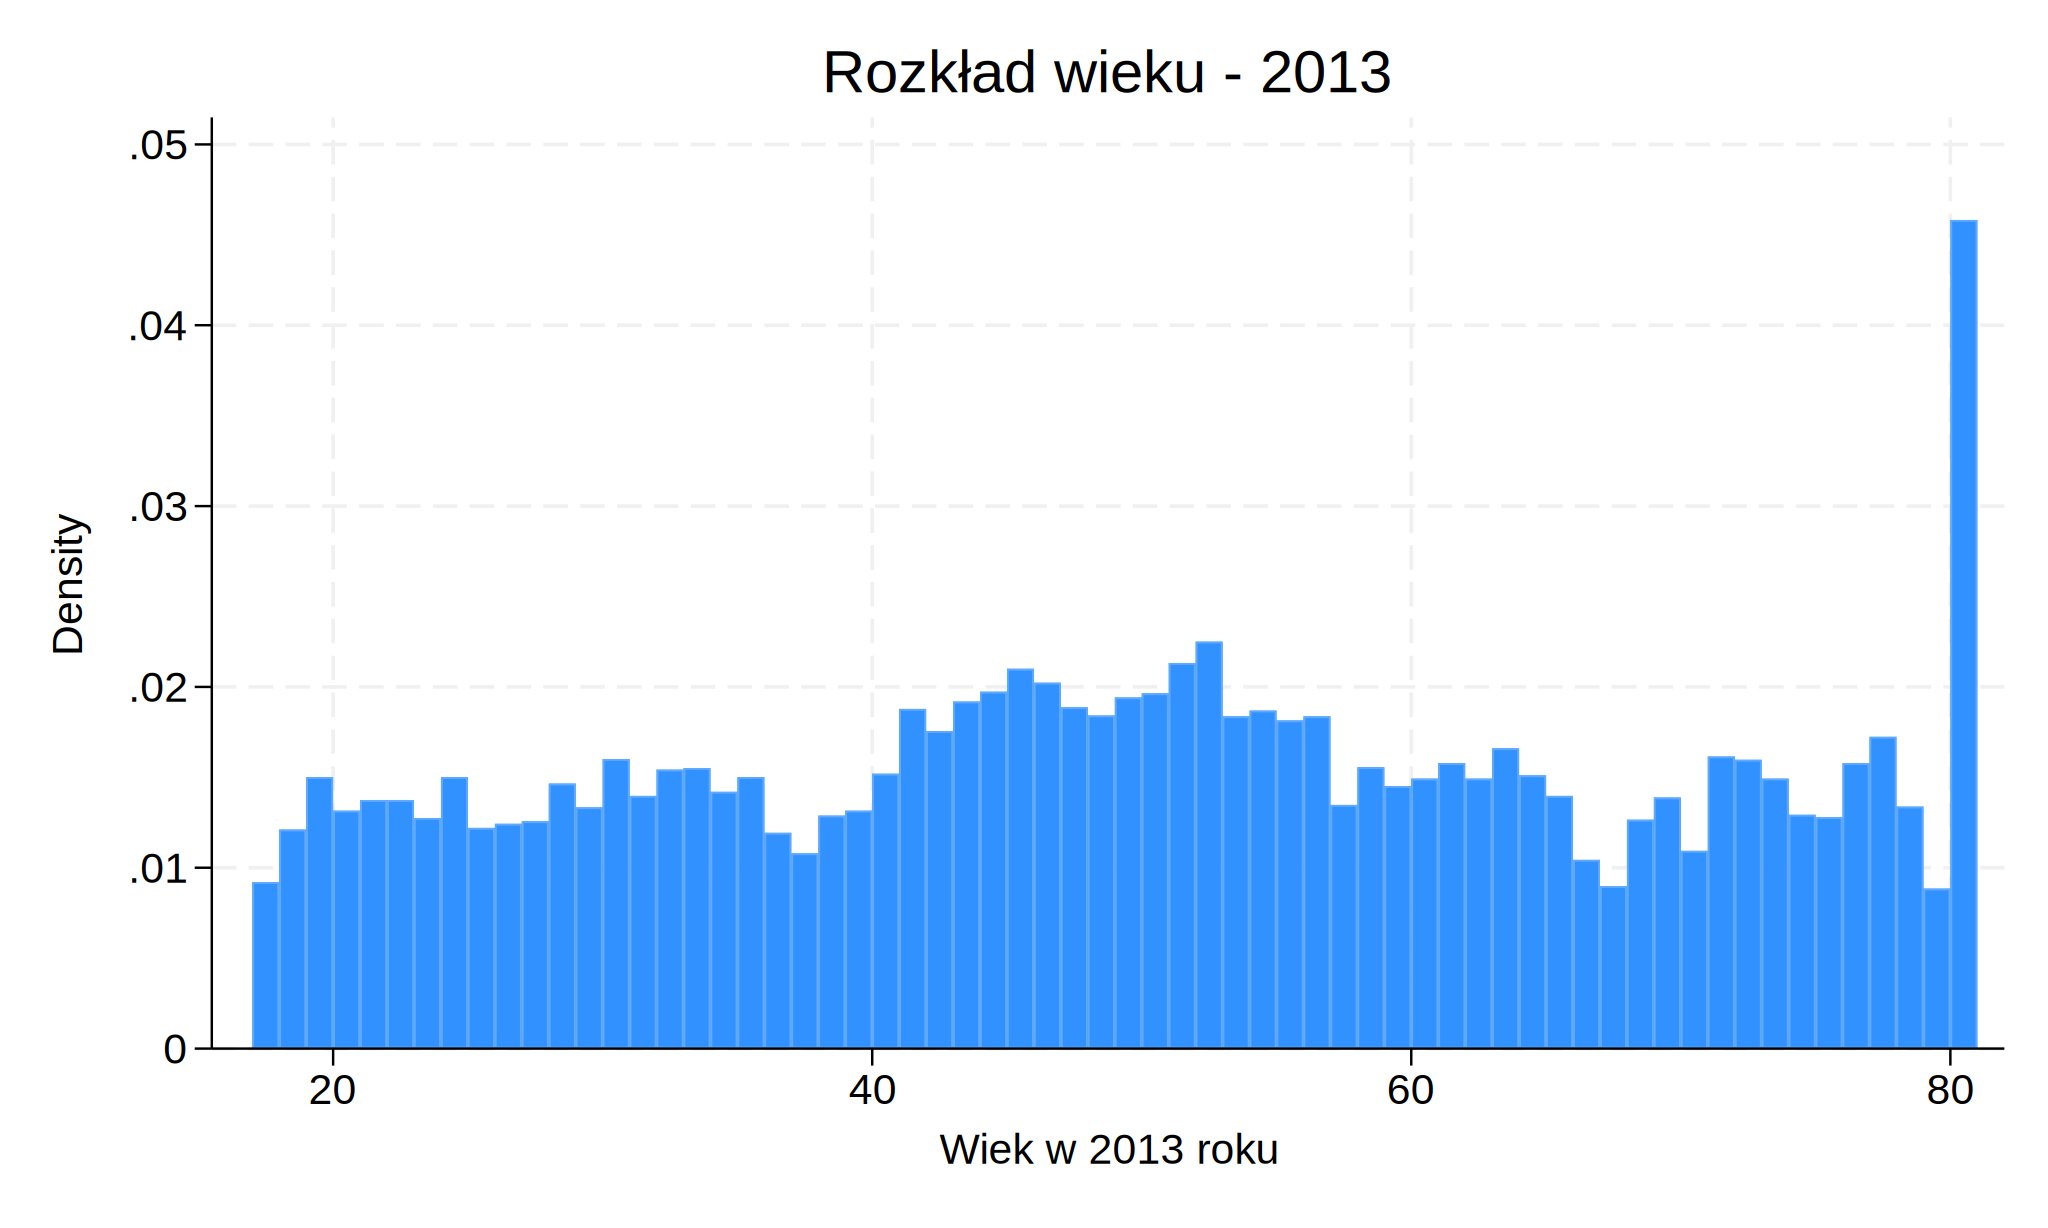

In [14]:
pystata.stata.run('''
* Wyznaczenie wieku dla wszystkich rekordów
gen age = PB110 - PB140
label var age "Wiek w 2013 roku"

* Sprawdzenie zakresu wieku
summarize age

* Histogram wieku
histogram age, width(1) title("Rozkład wieku - 2013")
graph export "age_histogram.png", replace

* Wyświetlenie pierwszych 10 obserwacji z kolumnami PB140 i age
list PB140 age in 1/10
''')

### Income

In [15]:
pystata.stata.run('''
    * --- TWORZENIE ZMIENNYCH KOMPOZYTOWYCH ---

    * 1. Dochód gotówkowy + bezgotówkowy
    gen income = PY010G + PY020G

    label var income "Cash and Non-Cash Income"
    keep if income >= 0
''')


. 
.     * --- TWORZENIE ZMIENNYCH KOMPOZYTOWYCH ---
. 
.     * 1. Dochód gotówkowy + bezgotówkowy
.     gen income = PY010G + PY020G
(5 missing values generated)

. 
.     label var income "Cash and Non-Cash Income"

.     keep if income >= 0
(10 observations deleted)

. 



. 
.     * Histogram wieku
.     summarize income

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
      income |     22,026     16025.2    24243.17          0     597560

.     histogram income, normal
(bin=43, start=0, width=13896.744)

.     graph export "income_histogram.png", replace
file income_histogram.png written in PNG format

. 


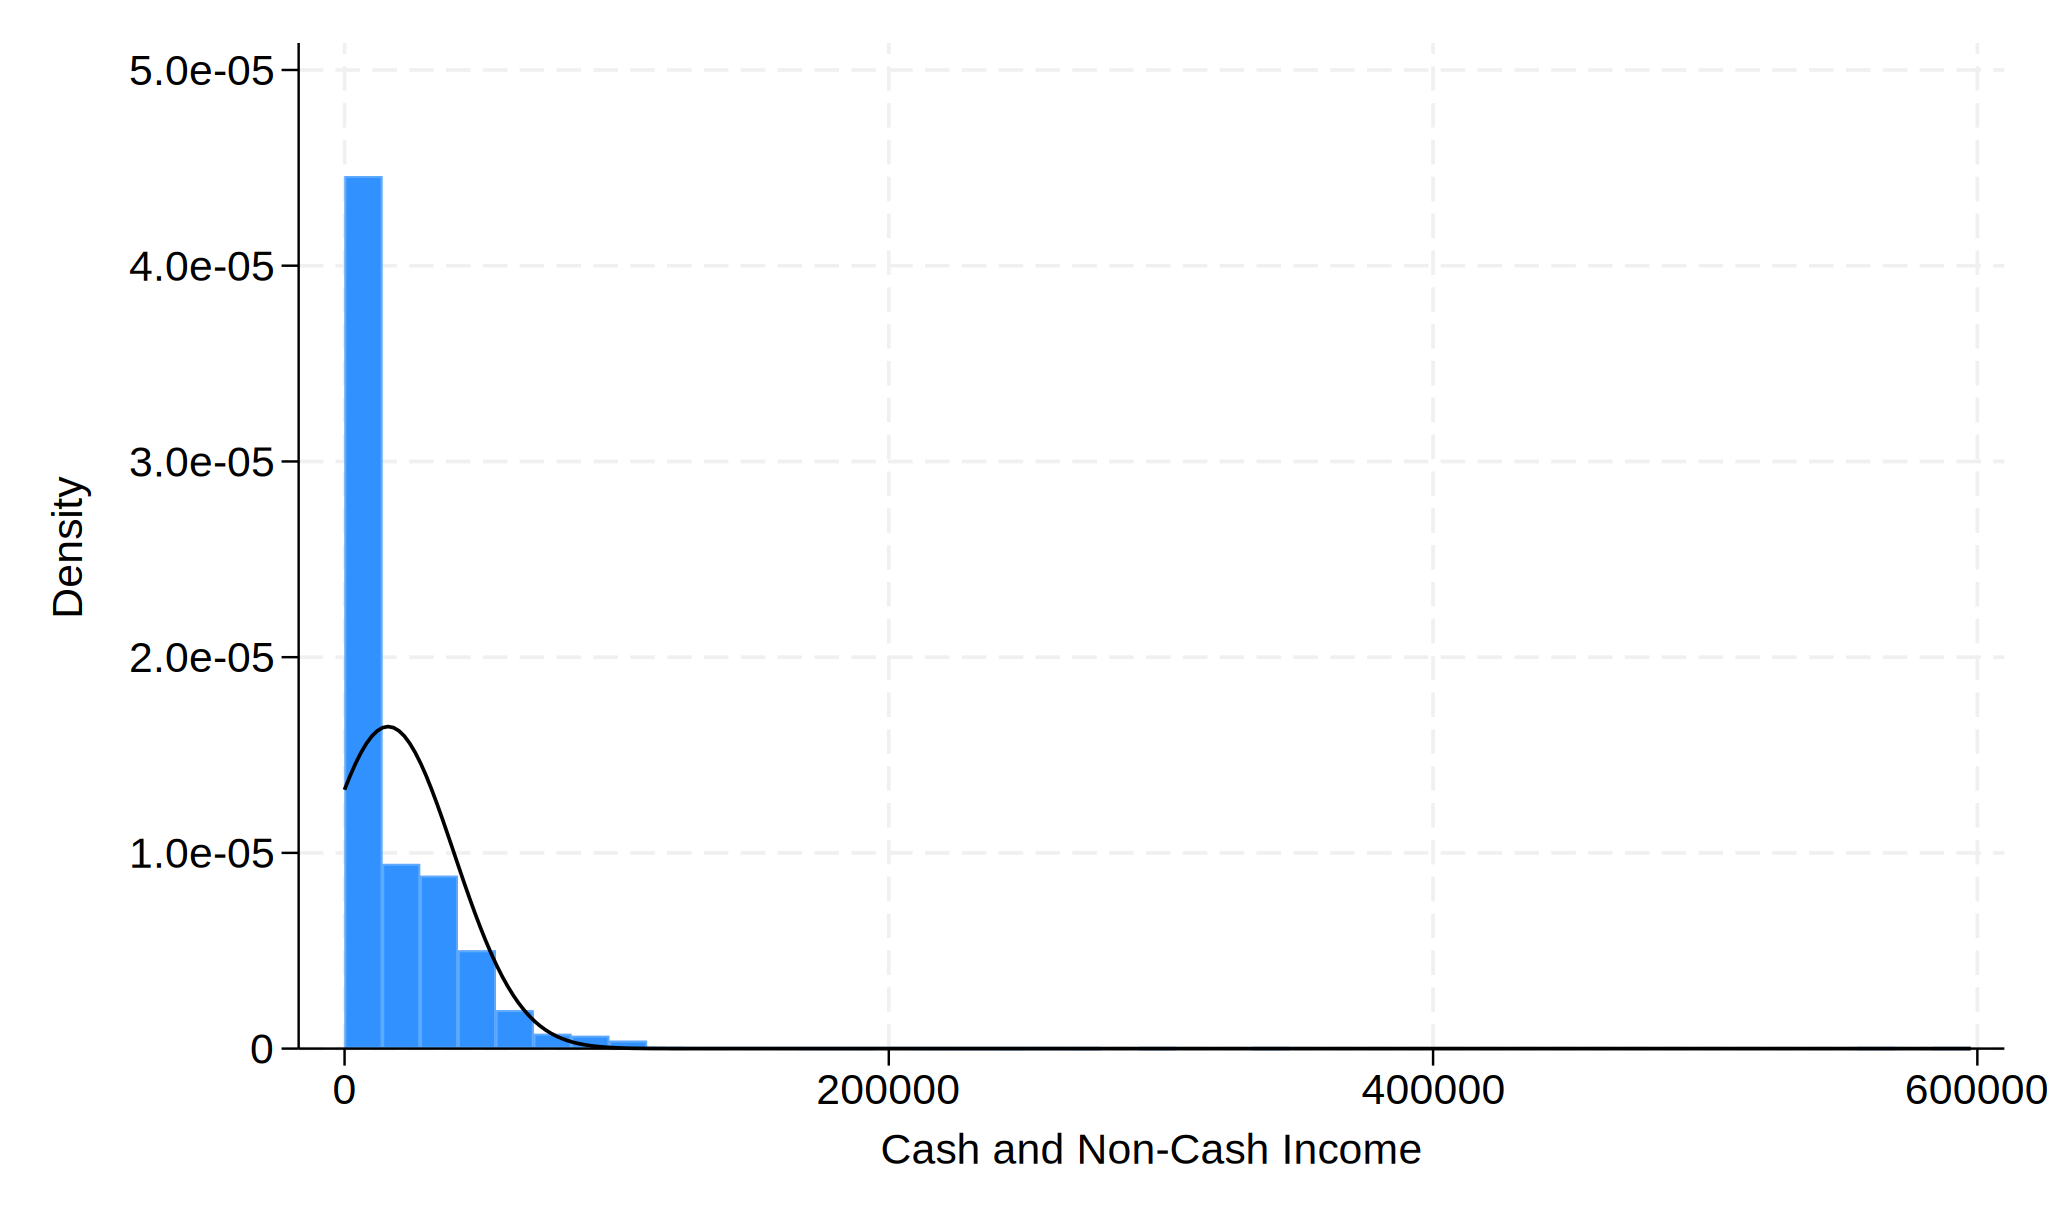

In [16]:
pystata.stata.run('''
    * Histogram wieku
    summarize income
    histogram income, normal
    graph export "income_histogram.png", replace
''')

### Variable benefits_allowances - social

In [17]:
pystata.stata.run('''
destring PY110G, replace force
destring PY120G, replace force
''')
pystata.stata.run('''
    * 2. Zasiłki, świadczenia, transfery
    gen benefits_allowances = PY090 + PY100G + PY110G + PY120G
    label var benefits_allowances "Benefits and Allowances"
    keep if benefits_allowances >= 0
''')


. 
. destring PY110G, replace force


PY110G: contains nonnumeric characters; replaced as double
(1 missing value generated)

. destring PY120G, replace force
PY120G: contains nonnumeric characters; replaced as double
(6 missing values generated)

. 

. 
.     * 2. Zasiłki, świadczenia, transfery
.     gen benefits_allowances = PY090 + PY100G + PY110G + PY120G
(13 missing values generated)

.     label var benefits_allowances "Benefits and Allowances"

.     keep if benefits_allowances >= 0
(3 observations deleted)

. 


In [18]:
pystata.stata.run('''
    * 3. Sprawdzenie rozkładu zmiennych
    summarize income benefits_allowances
''')


. 
.     * 3. Sprawdzenie rozkładu zmiennych
.     summarize income benefits_allowances

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
      income |     22,023    16027.04    24244.27          0     597560
benefits_a~s |     22,015    5673.204    11690.51          0     223825

. 


### Total hours of work

In [19]:
pystata.stata.run('''
    * 2. Total Hours Worked (PL060 + PL100)
    gen total_hours = PL060 + PL100
    label var total_hours "Total Hours Worked (Main + Additional Jobs)"
''')


. 
.     * 2. Total Hours Worked (PL060 + PL100)
.     gen total_hours = PL060 + PL100
(21,388 missing values generated)

.     label var total_hours "Total Hours Worked (Main + Additional Jobs)"

. 


# Variable work over_40_hours

In [20]:
pystata.stata.run('''
    * 3. Binary Variable - Over 40 Hours
    gen over_40_hours = (total_hours > 40)
    label define over40 0 "40 hours or less" 1 "Over 40 hours"
    label values over_40_hours over40
    label var over_40_hours "Worked Over 40 Hours"
''')


. 
.     * 3. Binary Variable - Over 40 Hours
.     gen over_40_hours = (total_hours > 40)

.     label define over40 0 "40 hours or less" 1 "Over 40 hours"

.     label values over_40_hours over40

.     label var over_40_hours "Worked Over 40 Hours"

. 


### Health score

In [21]:
pystata.stata.run('''
    * Tworzenie zmiennej health_score
    gen health_score = .

    * Poważne problemy zdrowotne (choroba przewlekła + silne ograniczenie aktywności)
    replace health_score = 3 if PH020 == 1 & PH030 == 1

    * Ograniczone problemy zdrowotne (choroba przewlekła lub umiarkowane ograniczenie)
    replace health_score = 2 if (PH020 == 1 & PH030 != 1) | (PH030 == 2)

    * Brak problemów zdrowotnych
    replace health_score = 1 if PH020 == 2 & PH030 == 3

    * Missing values
    replace health_score = . if PH020 == -1 | PH020 == -3 | PH030 == -1 | PH030 == -3

    * Etykiety
    label define health_lbl 1 "No Health Issues" 2 "Mild Issues" 3 "Severe Issues"
    label values health_score health_lbl
    label var health_score "General Health Score"

''')


. 
.     * Tworzenie zmiennej health_score
.     gen health_score = .
(22,028 missing values generated)

. 
.     * Poważne problemy zdrowotne (choroba przewlekła + silne ograniczenie akt
> ywności)
.     replace health_score = 3 if PH020 == 1 & PH030 == 1
(817 real changes made)

. 
.     * Ograniczone problemy zdrowotne (choroba przewlekła lub umiarkowane ogra
> niczenie)
.     replace health_score = 2 if (PH020 == 1 & PH030 != 1) | (PH030 == 2)
(10,180 real changes made)

. 
.     * Brak problemów zdrowotnych
.     replace health_score = 1 if PH020 == 2 & PH030 == 3
(8,400 real changes made)

. 
.     * Missing values
.     replace health_score = . if PH020 == -1 | PH020 == -3 | PH030 == -1 | PH0
> 30 == -3
(0 real changes made)

. 
.     * Etykiety
.     label define health_lbl 1 "No Health Issues" 2 "Mild Issues" 3 "Severe Is
> sues"

.     label values health_score health_lbl

.     label var health_score "General Health Score"

. 
. 


In [22]:
pystata.stata.run('''
    summarize health_score
''')


. 
.     summarize health_score

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
health_score |     19,397    1.609063     .567769          1          3

. 


In [23]:
pystata.stata.run('''
    * 5. Employment Status (PL040, PL020, PL015)
    gen employment_status = PL040

    * Reclassify Employment Status for Unemployed
    replace employment_status = 1 if PL040 == 0 & PL020 == 1
    replace employment_status = 2 if PL040 == 0 & PL015 == 1
    label define emp_status 0 "Employed" 1 "Actively Seeking" 2 "Never Worked"
    label values employment_status emp_status
    label var employment_status "Employment Status"
''')


. 
.     * 5. Employment Status (PL040, PL020, PL015)
.     gen employment_status = PL040
(1,627 missing values generated)

. 
.     * Reclassify Employment Status for Unemployed
.     replace employment_status = 1 if PL040 == 0 & PL020 == 1
(0 real changes made)

.     replace employment_status = 2 if PL040 == 0 & PL015 == 1
(0 real changes made)

.     label define emp_status 0 "Employed" 1 "Actively Seeking" 2 "Never Worked
> "

.     label values employment_status emp_status

.     label var employment_status "Employment Status"

. 


### Trust group


. 
.     * Zamiana wartości 99 na missing
.     mvdecode PW130 PW140 PW150, mv(99)
       PW130: 801 missing values generated
       PW140: 733 missing values generated
       PW150: 623 missing values generated

.     * Tworzenie zmiennej trust_index jako średniej z dostępnych wartości
.     egen trust_index = rowmean(PW130 PW140 PW150)
(138 missing values generated)

.     label var trust_index "Average Trust Index (Political, Legal, Police)"

.     summarize trust_index

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
 trust_index |     21,890    5.529656    1.728873          0         10

.     histogram trust_index, bin(20) normal title("Trust Index Distribution")
(bin=20, start=0, width=.5)

. 
. 


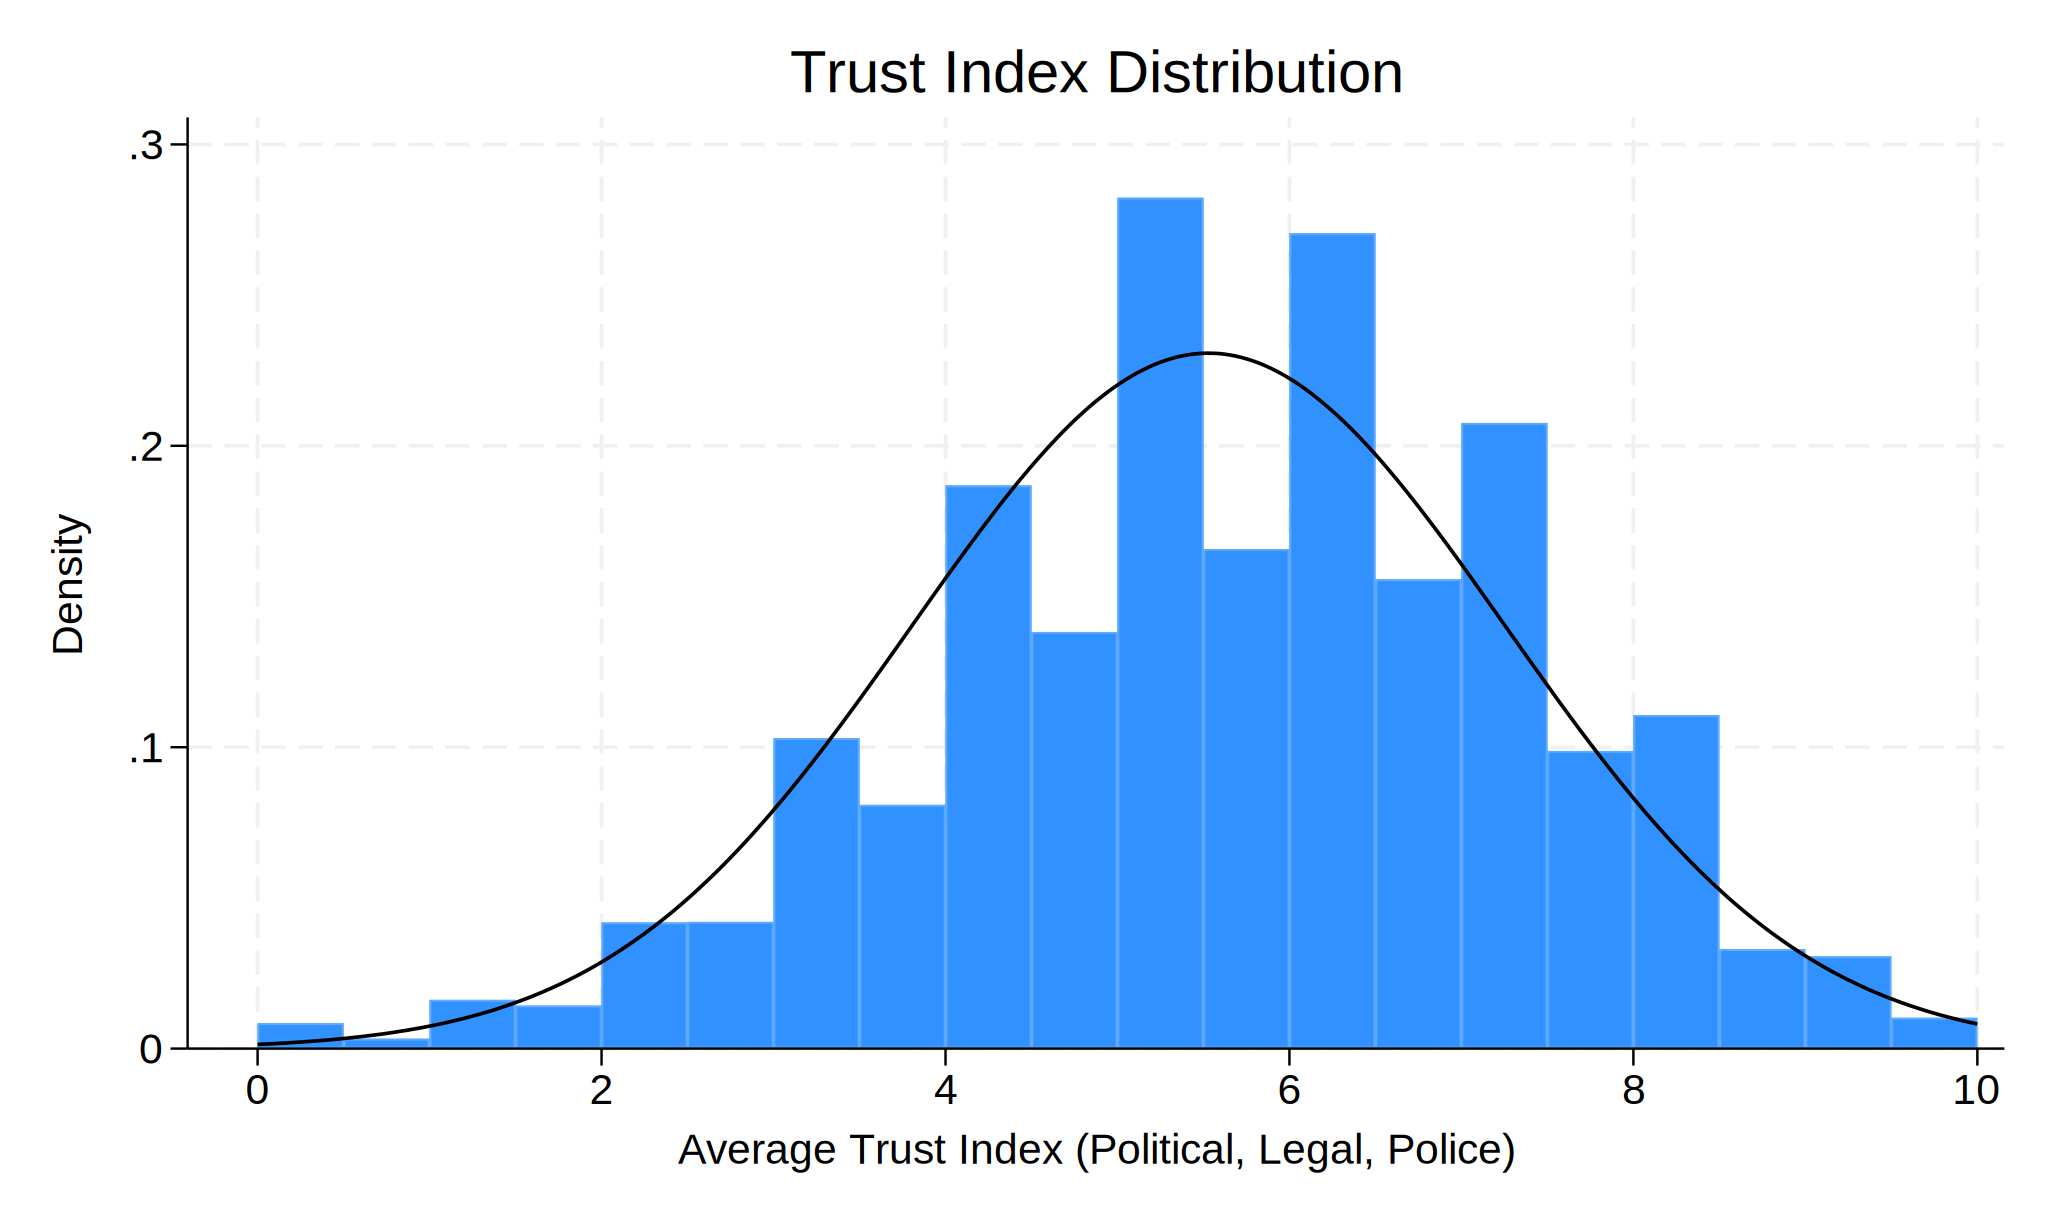

In [24]:
pystata.stata.run('''
    * Zamiana wartości 99 na missing
    mvdecode PW130 PW140 PW150, mv(99)
    * Tworzenie zmiennej trust_index jako średniej z dostępnych wartości
    egen trust_index = rowmean(PW130 PW140 PW150)
    label var trust_index "Average Trust Index (Political, Legal, Police)"
    summarize trust_index
    histogram trust_index, bin(20) normal title("Trust Index Distribution")

''')

In [25]:
pystata.stata.run('''
gen trust_group = .
replace trust_group = 1 if trust_index < 3
replace trust_group = 2 if trust_index >= 3 & trust_index <= 7
replace trust_group = 3 if trust_index > 7

label define trust_lbl 1 "Low Trust" 2 "Moderate Trust" 3 "High Trust"
label values trust_group trust_lbl
''')
print("\nComposite data created succesfuly")



. 
. gen trust_group = .
(22,028 missing values generated)

. replace trust_group = 1 if trust_index < 3
(1,379 real changes made)

. replace trust_group = 2 if trust_index >= 3 & trust_index <= 7
(16,851 real changes made)

. replace trust_group = 3 if trust_index > 7
(3,798 real changes made)

. 
. label define trust_lbl 1 "Low Trust" 2 "Moderate Trust" 3 "High Trust"

. label values trust_group trust_lbl

. 

Composite data created succesfuly


**Check new variables**


. 
.     summarize trust_group

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
 trust_group |     22,028    2.109815    .4721969          1          3

.     histogram trust_group
(bin=43, start=1, width=.04651163)



.     tabstat income, by(trust_group) statistics(mean sd min max)

Summary for variables: income
Group variable: trust_group 

   trust_group |      Mean        SD       Min       Max
---------------+----------------------------------------
     Low Trust |   16121.4  22053.51         0  175235.3
Moderate Trust |  16032.97  24493.94         0  583868.5
    High Trust |   15966.5  23893.62         0    597560
---------------+----------------------------------------
         Total |  16027.04  24244.27         0    597560
--------------------------------------------------------

. 


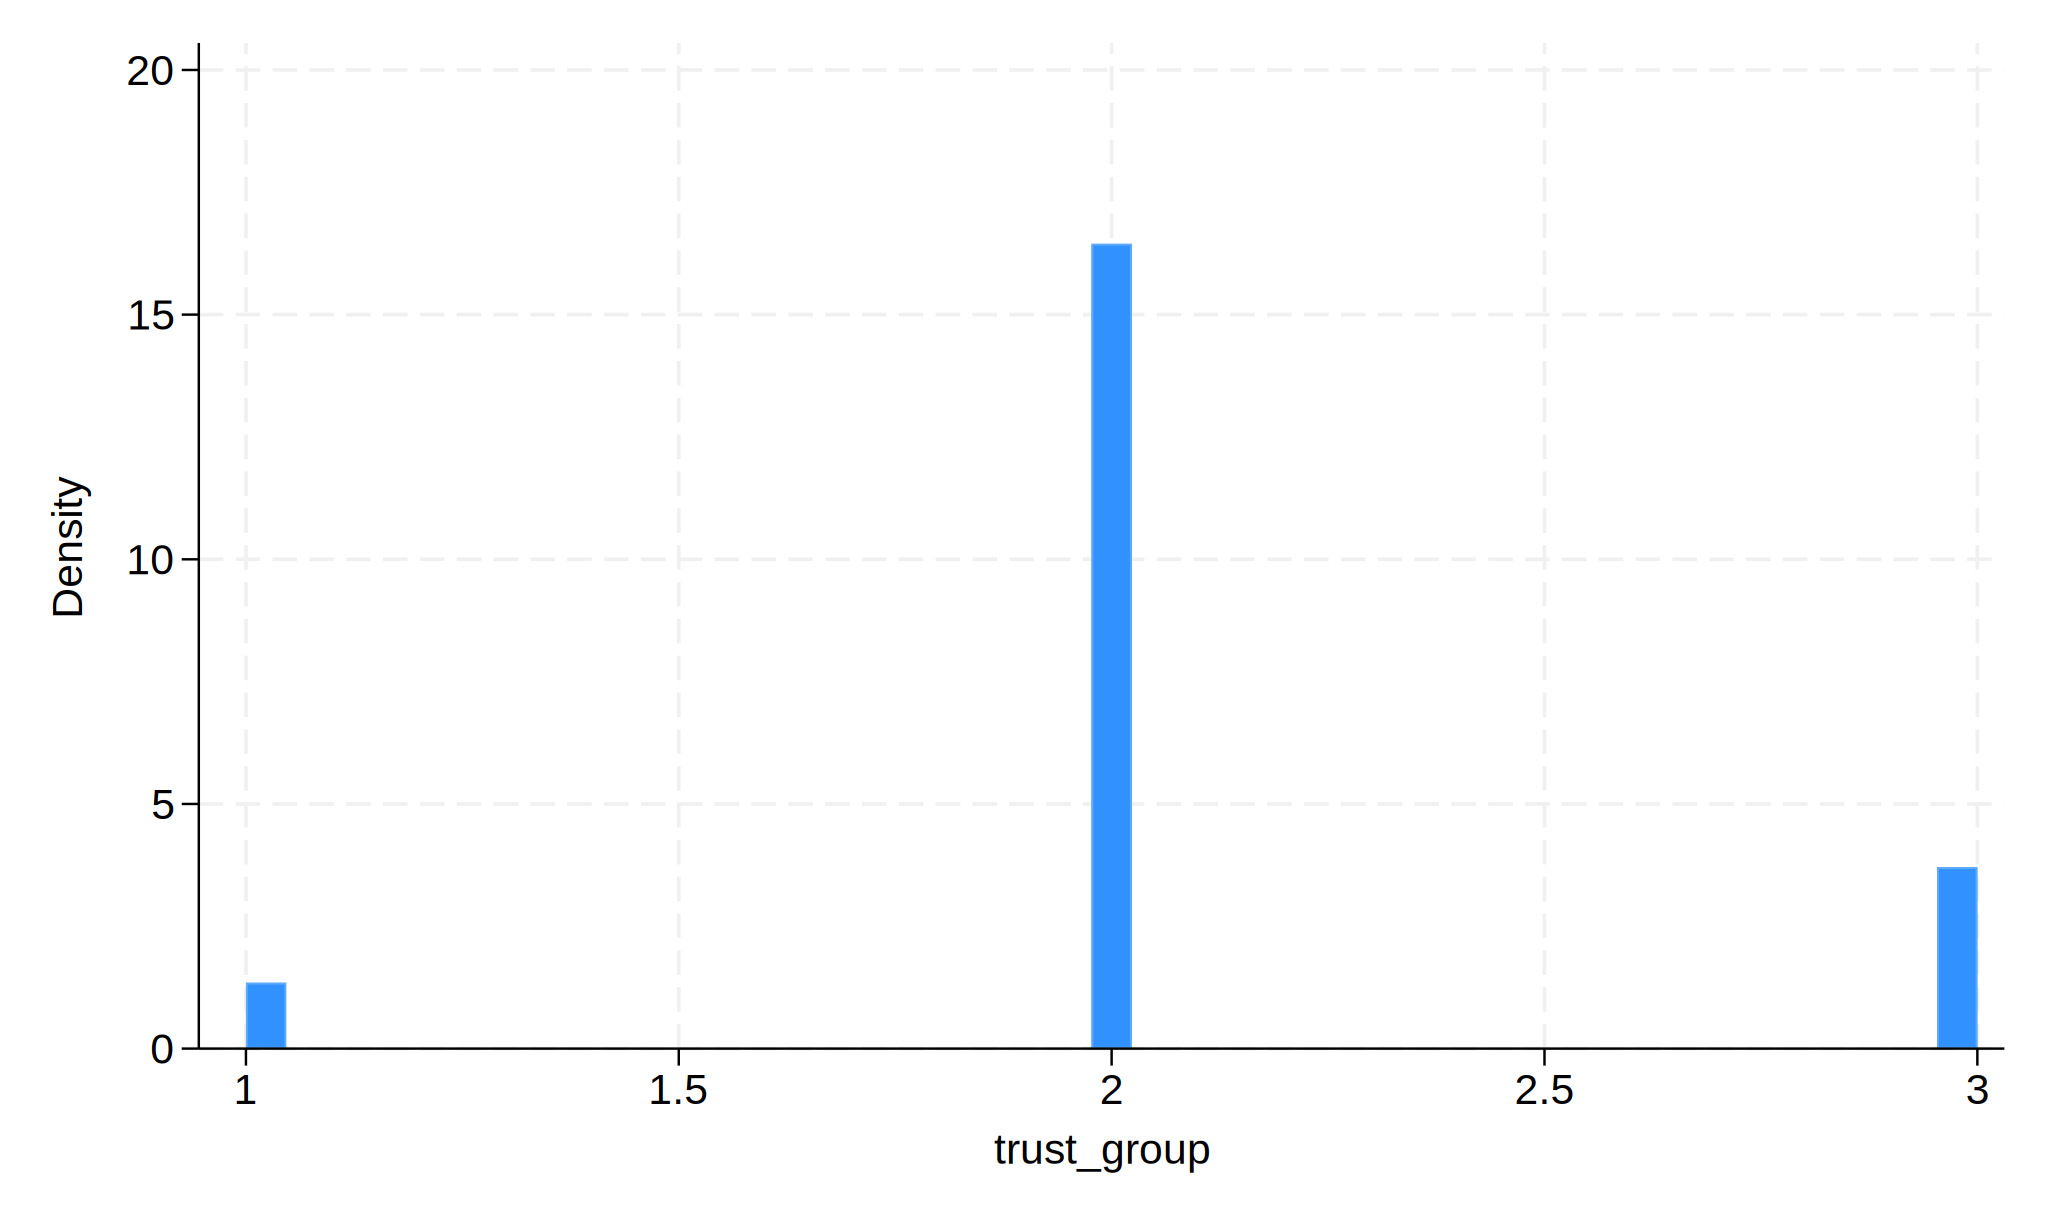

In [26]:
pystata.stata.run('''
    summarize trust_group
    histogram trust_group
    tabstat income, by(trust_group) statistics(mean sd min max)
''')


. 
.     summarize benefits_allowances

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
benefits_a~s |     22,015    5673.204    11690.51          0     223825

.     histogram benefits_allowances, normal
(bin=43, start=0, width=5205.2329)

. 


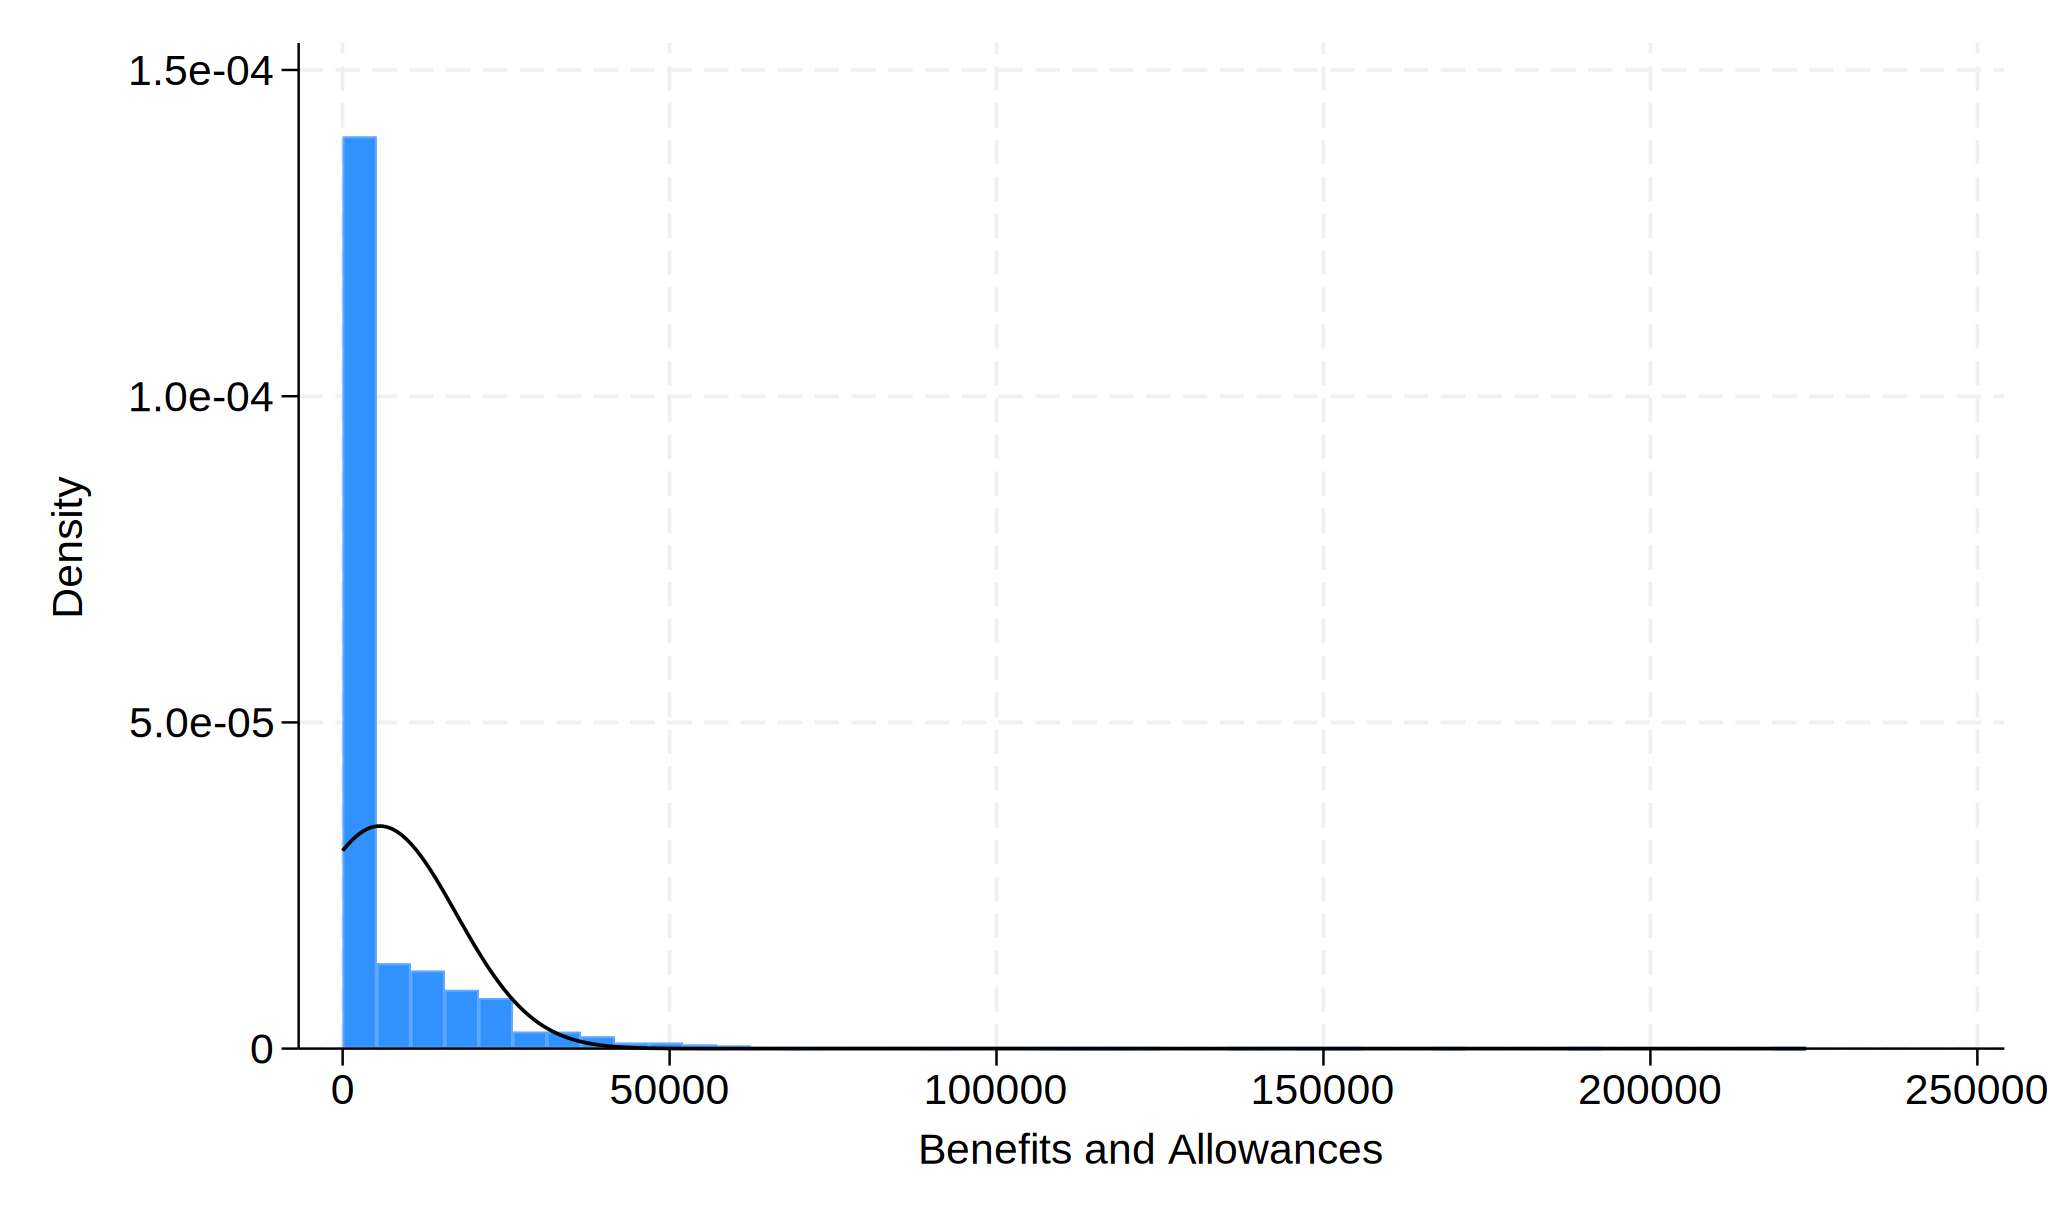

In [27]:
pystata.stata.run('''
    summarize benefits_allowances
    histogram benefits_allowances, normal
''')


. 
.     summarize total_hours

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
 total_hours |        640        46.9    11.16525          7         92

.     histogram total_hours, normal
(bin=25, start=7, width=3.4)

. 


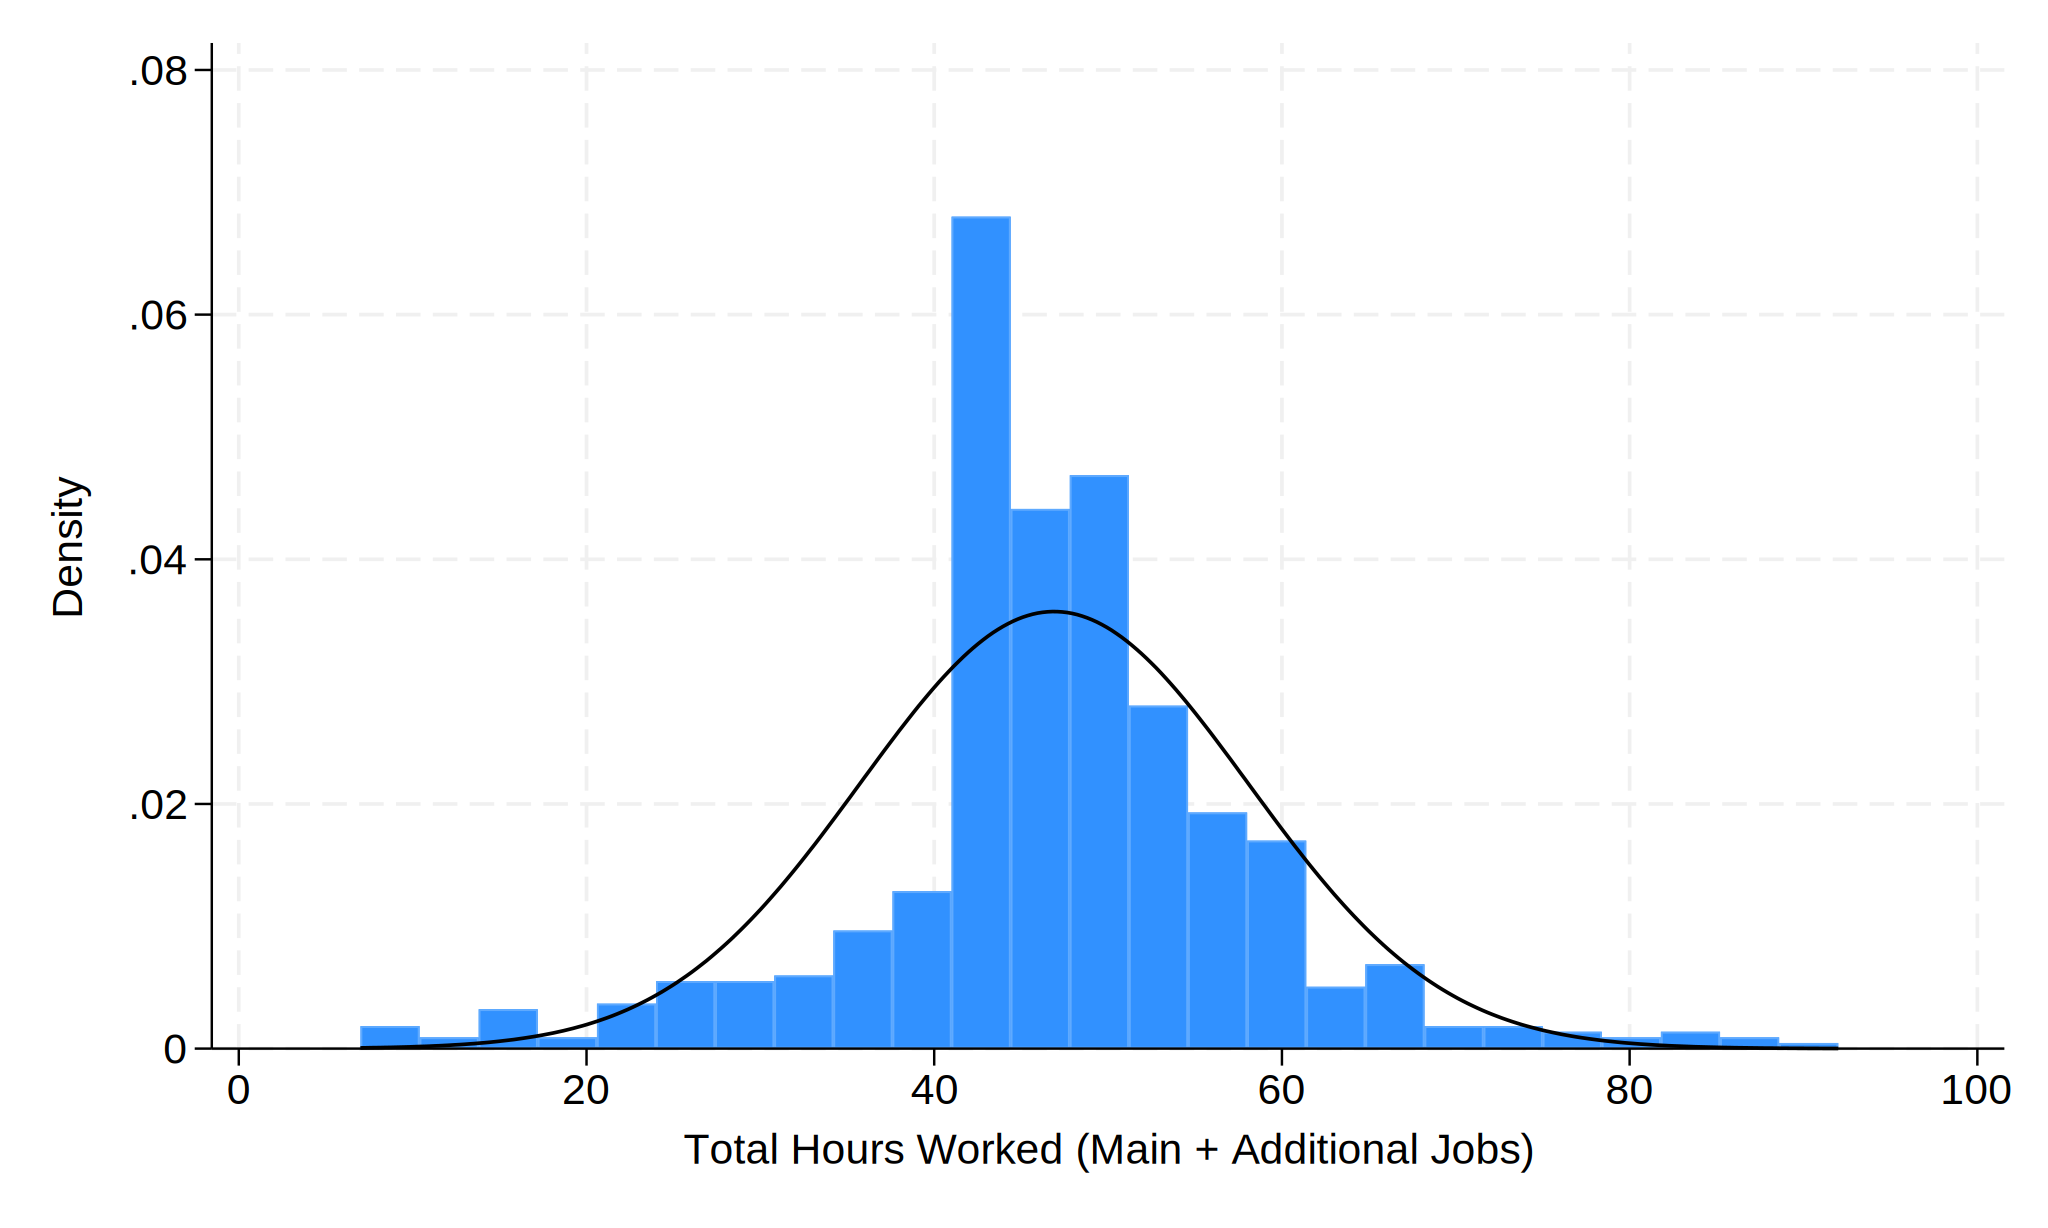

In [28]:
pystata.stata.run('''
    summarize total_hours
    histogram total_hours, normal
''')

In [29]:
pystata.stata.run('''
    tabulate over_40_hours
''')


. 
.     tabulate over_40_hours

  Worked Over 40 |
           Hours |      Freq.     Percent        Cum.
-----------------+-----------------------------------
40 hours or less |        109        0.49        0.49
   Over 40 hours |     21,919       99.51      100.00
-----------------+-----------------------------------
           Total |     22,028      100.00

. 


### Sheerp Regression Discontinuity Design (**RDD**)

Regression Discontinuity Design (RDD) is a method for estimating a causal effect (the influence of one variable on another, assuming a causal relationship) based on discrete changes in the assignment of units to the treatment and control groups that result from the crossing of a specified threshold.

RDD is particularly useful when randomization is not possible but there is a clearly defined assignment rule based on a continuous variable.


**Why Do We Choose RDD?**

- **Natural Discontinuity Point:** Working **more than 40 hours** is a natural discontinuity point that can lead to overwork and stress.

- **Potential Causal Effect:** People working **more than 40 hours** may experience greater stress, which may affect their perception of public institutions.

- **Policy Issue:** Analyzing the impact of overwork on trust in institutions may be useful from a labor policy perspective.

### Sharp RDD implementation

In [30]:
# Implementacja Sharp RDD
pystata.stata.run('''
    * --- RDD ANALIZA ---

    * 1. Definiowanie zmiennych
    * Upewnijmy się, że zmienna over_40_hours jest poprawnie zakodowana
    replace over_40_hours = (total_hours > 40)
    label define over40 0 "40 hours or less" 1 "Over 40 hours"
    label values over_40_hours over40

    * 2. Wykres diagnostyczny
    twoway (scatter trust_index total_hours) ///
           (lfit trust_index total_hours if over_40_hours == 0) ///
           (lfit trust_index total_hours if over_40_hours == 1), ///
           title("RDD Analysis: Impact of Working Over 40 Hours on Trust Index") ///
           ytitle("Trust Index") ///
           xtitle("Total Hours Worked")
    graph export "rdd_diagnostic.png", replace

    * 3. Implementacja Sharp RDD
    * Model liniowy po obu stronach progu
    reg trust_index over_40_hours c.total_hours##over_40_hours

    * 4. Wyniki regresji
    estat summarize
''')

print("\nRDD analiza zakończona. Wykres diagnostyczny zapisany jako 'rdd_diagnostic.png'.")


SystemError: 
. 
.     * --- RDD ANALIZA ---
. 
.     * 1. Definiowanie zmiennych
.     * Upewnijmy się, że zmienna over_40_hours jest poprawnie zakodowana
.     replace over_40_hours = (total_hours > 40)
(0 real changes made)

.     label define over40 0 "40 hours or less" 1 "Over 40 hours"
label over40 already defined
r(110);
r(110);
